In [1]:
import time
import numpy as np
import matplotlib.pylab as plt 
import emcee
from getdist import plots, MCSamples
import getdist
import scipy.stats as ss 
import pandas as pd

import numpyro 
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_value
from numpyro.handlers import seed
from numpyro.distributions import constraints
from numpyro.diagnostics import summary
from jax import grad, jit, vmap, jacfwd, jacrev
from utils.helpers import dill_save, dill_load

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [33]:
ndim = 6
nchain = 2
tree_depth = 8
stepsize = 0.01
nsamples_nuts = 15000
nwarmup = 500

thin = 10
discard = 100
nsamples_emcee = int((nsamples_nuts * thin) / (2 * ndim) + discard)
fiducial = np.ones(ndim)
normal_prior = ss.norm(0, 1)

delta = 2.0
uniform_prior = ss.uniform(-delta, 2*delta)

In [3]:
def rosenbrock(xvalues):
    x_i_plus_one = xvalues[1::2]
    x_i = xvalues[0::2]
    term_1 = 9.0 * (x_i_plus_one - x_i**2)**2
    term_2 = (x_i - 1)**2
    return sum(term_1 + term_2)
    
def loglikelihood(xvalues):
    return -rosenbrock(xvalues)

@jax.jit
def jit_loglike(xvalues):
    return loglikelihood(xvalues)

@jax.jit
def jit_grad_loglike(xvalues):
    return jax.jacfwd(loglikelihood)(xvalues)
    
def logposterior(xvalues):
    # logprior = sum([uniform_prior.logpdf(xvalues[i]) for i in range(ndim)])
    logprior = sum([normal_prior.logpdf(xvalues[i]) for i in range(len(xvalues))])
    if np.isfinite(logprior):
        return logprior + jit_loglike(xvalues)
    return -1E32

def calculate_summary(samples_1, samples_2, nlike, ndecimal = 3):
    record = []
    for i in range(samples_1.shape[1]):
        testsamples = np.vstack(([samples_1[:,i], samples_2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[f'p_{i}'] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(ndecimal).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['n_eff'] /= nlike
    return record_df

# $\frac{\tau[\nabla \mathcal{L}]}{\tau[\mathcal{L}]}$

In [39]:
%%timeit 
jit_loglike(fiducial)

37.8 µs ± 6.76 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [40]:
%%timeit
jit_loglike(fiducial)

34.7 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [41]:
%%timeit
jit_grad_loglike(fiducial)

32.2 µs ± 420 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [42]:
%%timeit
jit_grad_loglike(fiducial)

38.4 µs ± 6.57 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [43]:
dimensions = np.arange(1, 6, 1, dtype = int) * 20
nrepeat = 10

tau_like = []
tau_gradlike = []

for repeat in range(nrepeat):
    record_tau_like = []
    record_tau_grad_like = []
    
    for d in dimensions:
        testpoint = jnp.ones(d) + 1E-2
        
        start_time = time.time()
        loglike = jit_loglike(testpoint)
        time_taken = time.time() - start_time 
        record_tau_like.append(time_taken)
        
        start_time = time.time()
        grad_loglike = jit_grad_loglike(testpoint)
        time_taken = time.time() - start_time 
        record_tau_grad_like.append(time_taken)
    
    record_tau_like = np.asarray(record_tau_like)
    record_tau_grad_like = np.asarray(record_tau_grad_like)
    tau_like.append(record_tau_like)
    tau_gradlike.append(record_tau_grad_like)

tau_like = np.asarray(tau_like)
tau_gradlike = np.asarray(tau_gradlike)

In [44]:
time_ratio = np.mean(tau_gradlike / tau_like, axis = 0)
time_ratio_error = np.std(tau_gradlike / tau_like, axis = 0)

In [10]:
# dill_save(time_ratio, 'rosenbrock', 'gL_L_time_ratio')
# dill_save(time_ratio_error, 'rosenbrock', 'gL_L_time_ratio_error')

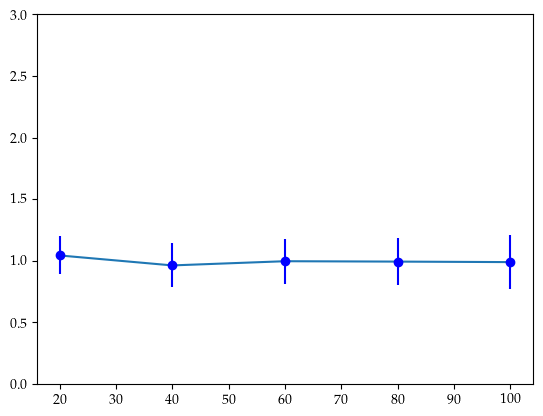

In [45]:
plt.plot(dimensions, time_ratio)
plt.errorbar(dimensions, time_ratio, yerr = time_ratio_error,fmt = 'bo')
plt.ylim(0, 3)
plt.show()

## EMCEE

In [4]:
def single_emcee_run(fiducial, thin = thin, ndim = ndim):
    pos = fiducial + 1e-3 * np.random.randn(2*ndim, ndim)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    sampler.run_mcmc(pos, nsamples_emcee, progress=True)
    return sampler

def run_emcee(fiducial, discard = discard, thin = thin, ndim = ndim, nchain = 2):
    if nchain > 1:
        record_samples = []
        total_samples = 0
        for chain in range(nchain):
            sampler = single_emcee_run(fiducial, thin, ndim)
            emcee_samples = sampler.get_chain(discard = discard, thin = thin, flat = True)
            # emcee_samples = sampler.flatchain[::thin] 
            record_samples.append(emcee_samples)
            total_samples += sampler.flatchain.shape[0]
        return record_samples, total_samples
    
    sampler = single_emcee_run(fiducial, discard, thin, ndim)
    total_samples = sampler.flatchain.shape[0]
    emcee_samples = sampler.get_chain(discard = discard, thin = thin, flat = True)
    # emcee_samples = sampler.flatchain[::thin]
    return emcee_samples, total_samples

In [34]:
emcee_samples, nlike_emcee = run_emcee(fiducial, discard, thin, ndim, nchain = nchain)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 12600/12600 [01:44<00:00, 120.43it/s]


In [35]:
calculate_summary(emcee_samples[0], emcee_samples[1], nlike_emcee)

,r_hat,n_eff,mean,std
p_0,1.001,0.096672,0.438,0.448
p_1,1.001,0.097888,0.367,0.464
p_2,1.002,0.098007,0.468,0.449
p_3,1.002,0.094728,0.397,0.477
p_4,1.000,0.096872,0.459,0.442
p_5,1.000,0.090124,0.383,0.475


## NUTS

In [7]:
def model(ndim):
    xvalues = jnp.zeros(ndim)
    for i in range(ndim):
        # y = numpyro.sample(f"x{i}", dist.Uniform(-delta, delta))
        y = numpyro.sample(f"x{i}", dist.Normal(0, 1))
        xvalues = xvalues.at[i].set(y)
    numpyro.factor("log_prob", jit_loglike(xvalues))

In [8]:
%%capture
def run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim = ndim, nchain = 2):
    init_strategy = init_to_value(
                values={f"x{i}": 1.0 for i in range(ndim)}
            )
    nuts_kernel = NUTS(model, step_size=stepsize, dense_mass=True, max_tree_depth=tree_depth, init_strategy=init_strategy)
    mcmc = MCMC(nuts_kernel, num_chains=nchain, num_warmup = nwarmup, num_samples=nsamples_nuts, chain_method='vectorized') 
    mcmc.run(jax.random.PRNGKey(0), ndim=ndim, extra_fields=('potential_energy', 'num_steps', 'accept_prob'))
    nlike_nuts = mcmc.get_extra_fields()['num_steps'].sum().item()
    return mcmc, nlike_nuts

In [9]:
def process_nuts_chains(mcmc, ndim = ndim):
    chains = mcmc.get_samples(group_by_chain = True)
    record = []
    for c in range(nchain):
        samples = np.vstack([np.asarray(chains[f'x{i}'][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [36]:
mcmc, nlike_nuts = run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 15500/15500 [00:55<00:00, 281.33it/s]


In [37]:
nuts_grouped = process_nuts_chains(mcmc, ndim)
nuts_samples = np.vstack([mcmc.get_samples()[f'x{i}'] for i in range(ndim)]).T

In [38]:
calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)

,r_hat,n_eff,mean,std
p_0,1.0,0.021576,0.458,0.447
p_1,1.0,0.032505,0.391,0.479
p_2,1.0,0.020508,0.453,0.458
p_3,1.0,0.033125,0.394,0.479
p_4,1.0,0.026699,0.452,0.455
p_5,1.0,0.043241,0.389,0.482


## Plots

In [39]:
emcee_samples_flat = np.concatenate(emcee_samples)

In [40]:
ndimplot = ndim # 10
names = ["x%s"%i for i in range(ndimplot)]
labels =  [f"$x_{i}$" for i in range(ndimplot)]
samples_emcee = MCSamples(samples=emcee_samples_flat[:,0:ndimplot],names = names, labels = labels)
samples_nuts = MCSamples(samples=nuts_samples[:,0:ndimplot],names = names, labels = labels)

Removed no burn in
Removed no burn in


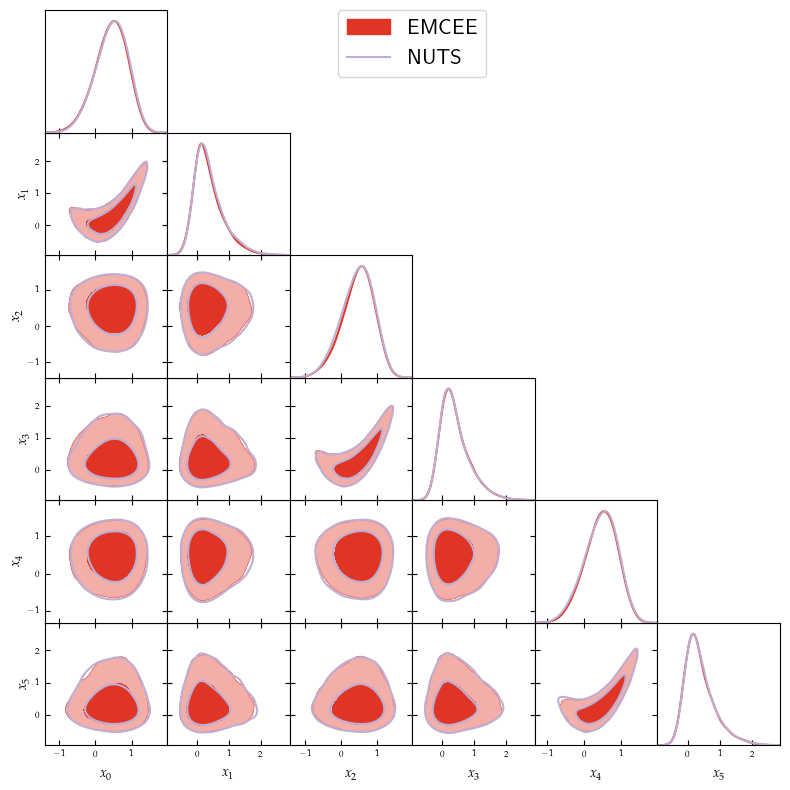

In [41]:
g = plots.get_subplot_plotter(width_inch=8)
g.settings.line_styles = 'Accent'
g.settings.legend_fontsize = 20
g.triangle_plot([samples_emcee, samples_nuts], filled=[True, False], contour_lws=1.5, legend_labels=['EMCEE', 'NUTS'])
plt.show()

# Many Dimensions

In [7]:
# testdim = np.arange(1, 6, 1) * 2
testdim = np.arange(1, 11, 1) * 20

In [25]:
stats_emcee = {}
nlike_emcee_record = {}
time_emcee = {}

for d in testdim:
    initial = np.ones(d)
    
    start_time = time.time()
    emcee_samples, nlike_emcee = run_emcee(initial, discard, thin, d, nchain = nchain)
    time_emcee[d] = time.time() - start_time 

    stats_emcee[d] = calculate_summary(emcee_samples[0], emcee_samples[1], nlike_emcee)
    nlike_emcee_record[d] = nlike_emcee

100%|████████████████████████████████████████████████████████████████████████████████████| 7600/7600 [11:28:13<00:00,  5.43s/it]


In [27]:
dill_save(stats_emcee, 'rosenbrock', 'stats_emcee')
dill_save(nlike_emcee_record, 'rosenbrock', 'nlike_emcee')
dill_save(time_emcee, 'rosenbrock', 'time_emcee')

In [ ]:
# stats_nuts = {}
# nlike_nuts_record = {}
# time_nuts = {}

# for d in testdim:
#     start_time = time.time()
#     mcmc, nlike_nuts = run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, d)
#     time_nuts[d] = time.time() - start_time 
    
#     nuts_grouped = process_nuts_chains(mcmc, d)
#     stats_nuts[d] = calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)
#     nlike_nuts_record[d] = nlike_nuts

# dill_save(stats_nuts, 'rosenbrock', 'stats_nuts')
# dill_save(nlike_nuts_record, 'rosenbrock', 'nlike_nuts')
# dill_save(time_nuts, 'rosenbrock', 'time_nuts')

## Calculations

In [4]:
stats_emcee = dill_load('rosenbrock', 'stats_emcee')
nlike_emcee = dill_load('rosenbrock', 'nlike_emcee')
time_emcee = dill_load('rosenbrock', 'time_emcee')

In [5]:
stats_nuts = {}
nlike_nuts = {}
time_nuts = {}

for i in range(10):
    d = (i+1) * 20 
    stats_nuts[d] = dill_load('rosenbrock', f'stats_nuts_{d}')
    nlike_nuts[d] = dill_load('rosenbrock', f'nlike_nuts_{d}')
    time_nuts[d] = dill_load('rosenbrock', f'time_nuts_{d}')

In [6]:
stats_nuts = stats_nuts[120] | stats_nuts[140] | stats_nuts[200]
nlike_nuts = nlike_nuts[120] | nlike_nuts[140] | nlike_nuts[200]
time_nuts = time_nuts[120] | time_nuts[140] | time_nuts[200]

In [7]:
testdim = np.arange(1, 6, 1) * 20
t_emcee_array = np.asarray(list(time_emcee.values()))[0: len(testdim)]
t_nuts_array = np.asarray(list(time_nuts.values()))[0: len(testdim)]

mean_neff_emcee = np.asarray([stats_emcee[d]['n_eff'].mean() for d in testdim]) / t_emcee_array
mean_neff_nuts = np.asarray([stats_nuts[d]['n_eff'].mean() for d in testdim]) / t_nuts_array

In [23]:
ratio_neff = mean_neff_nuts / mean_neff_emcee

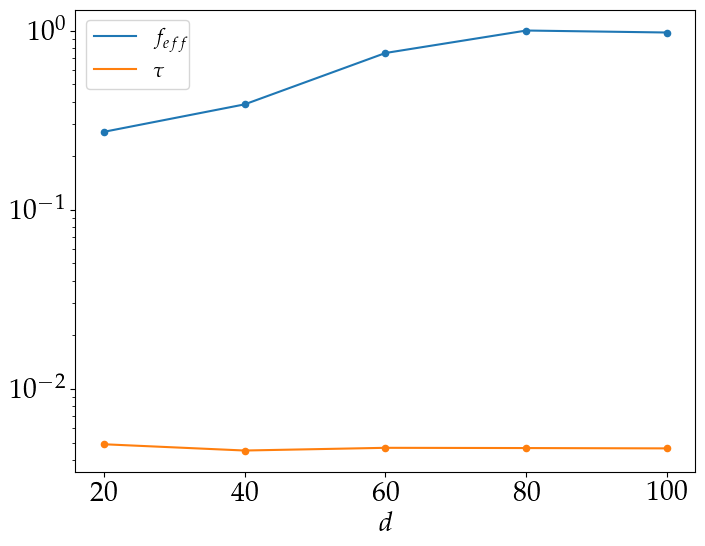

In [53]:
factor = max(ratio_neff)
plt.figure(figsize = (8, 6))
plt.plot(testdim, ratio_neff / factor, label = r'$f_{eff}$')
plt.scatter(testdim, ratio_neff/ factor, s = 20)
plt.plot(dimensions, time_ratio / factor, label = r'$\tau$')
plt.scatter(dimensions, time_ratio / factor, s = 20)
plt.xlabel(r'$d$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.yscale('log')
# plt.savefig('/home/arrykrishna/Desktop/ratio.pdf', bbox_inches = 'tight')
plt.show()

# Vary factor in Rosenbrock